# Output length predictor training

Alpaca data source: https://huggingface.co/datasets/yahma/alpaca-cleaned

## Data preprocessing

In [1]:
import numpy as np
import pandas as pd
from datasets import load_dataset, Dataset, DatasetDict

alpaca = load_dataset("yahma/alpaca-cleaned")

/n/holystore01/LABS/mzitnik_lab/Lab/yeh803/cache/miniforge3/envs/preble/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# sentences = ["test how are you", "how test", "do you know test"]  # FIXME

# # Load model from HuggingFace Hub
# tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
# bert_model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2', device_map="cpu")

# # Tokenize sentences
# encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

# # Compute token embeddings
# with torch.no_grad():
#     model_output = bert_model(**encoded_input)

# # Perform pooling
# sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# # Normalize embeddings
# sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

# print("Sentence embeddings:")
# # print(sentence_embeddings)
# sentence_embeddings.shape

Sentence embeddings:


torch.Size([3, 384])

In [2]:
# HF native
from functools import partial
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn as nn
import torch.nn.functional as F

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def get_token_len(sentences, tokenizer):
    encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
    return encoded_input["attention_mask"].detach().cpu().sum(dim=1).numpy()

tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
bert_model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2', device_map="cpu")

alpaca_df = list(alpaca.data.values())[0].to_pandas()
alpaca_df["output_token_len"] = get_token_len(alpaca_df["output"].values.tolist(), tokenizer)
alpaca_df

,output,input,instruction,output_token_len
0,1. Eat a balanced and nutritious diet: Make su...,,Give three tips for staying healthy.,151
1,"The three primary colors are red, blue, and ye...",,What are the three primary colors?,67
2,An atom is the basic building block of all mat...,,Describe the structure of an atom.,246
3,There are several ways to reduce air pollution...,,How can we reduce air pollution?,275
4,I had to make a difficult decision when I was ...,,Pretend you are a project manager of a constru...,153
...,...,...,...,...
51755,Yes,Text: John went out for a walk with his dog Ro...,You will be given a piece of text about an eve...,3
51756,True,Text: Michael Jordan is an American former pro...,You will be given a paragraph of text with var...,3
51757,True,Text: A tree fell over in the wind and caused ...,You will be given a piece of text about an eve...,3
51758,Backwards,"Steps: ['She takes out her books', 'The teache...",I will give you a list of steps. You need to ...,3


In [3]:
assert (alpaca_df["instruction"] == "").sum() == 0
assert (alpaca_df["input"] == "").sum() != 0

In [4]:
alpaca_df["input_text"] = alpaca_df[["input", "instruction"]].apply(
    lambda row: 
        row[1] + (
            "" if 
            row[1].endswith(".") or row[1].endswith("?") or row[1].endswith("!") or
            row[1].endswith("\n") or row[1].endswith(":")
            else "."
        ) + (
            ("" if row[1].endswith(" ") else " ") + \
            row[0] + (
                "" if row[1].endswith(".") or row[1].endswith("?") or 
                row[1].endswith("!") or row[1].endswith("\n") or row[1].endswith(":") 
                else "."
            ) if row[0] != "" else ""
        ),
    axis=1
)
alpaca_df["input_text"].values

/tmp/ipykernel_1539363/930882405.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row[1] + (
/tmp/ipykernel_1539363/930882405.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row[1].endswith(".") or row[1].endswith("?") or row[1].endswith("!") or
/tmp/ipykernel_1539363/930882405.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ) if row[0] != "" else ""
/tmp/ipykernel_1539363/930882405.py:6: FutureWarning: Series.__getitem_

array(['Give three tips for staying healthy.',
       'What are the three primary colors?',
       'Describe the structure of an atom.', ...,
       "You will be given a piece of text about an event that has happened. Your job is to determine if the event could have reasonably happened, based on your knowledge and commonsense. If it could have reasonably happened, output 'True', otherwise output 'False'. Text: A tree fell over in the wind and caused damage to my car.",
       "I will give you a list of steps.  You need to determine if the steps are going forwards or backwards in time by outputting 'Forwards' or 'Backwards'. Steps: ['She takes out her books', 'The teacher hands back the papers', 'She walks into class', 'The bell rings'].",
       "Given a piece of text, you need to output whether the statements made in the text are opinions or facts. An opinion is defined as a statement that cannot be proven true or false and is usually based on someone's beliefs. A fact is defined as a

<Axes: >

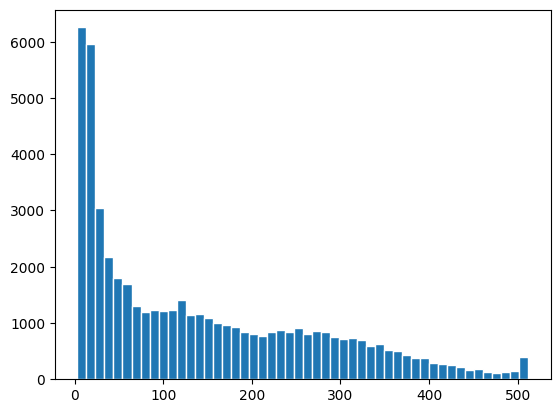

In [5]:
alpaca_hf = alpaca_df[["input_text", "output_token_len"]].rename(columns={"input_text": "text"})
alpaca_hf["output_token_len"].hist(ec="white", bins=50, grid=False)

In [6]:
# Define the number of buckets
num_buckets = 20

# Calculate the percentiles
percentiles = np.linspace(0, 100, num_buckets + 1)

# Get the bucket boundaries, with the last bucket's max set to 512
bucket_edges = list(np.percentile(alpaca_hf['output_token_len'], percentiles[:-1])) + [512]

# Create the bucket labels (max values for each bucket)
bucket_labels = np.arange(len(bucket_edges)-1)
bucket_max = bucket_edges[1:]

# Replace label values with the max value of the bucket
alpaca_hf['label'] = pd.cut(alpaca_hf['output_token_len'], bins=bucket_edges, include_lowest=True,
                            labels=bucket_labels, 
                            )
alpaca_hf['label'] = alpaca_hf['label'].astype(float)

In [ ]:
from sklearn.model_selection import train_test_split

# Split into train, validation, and test sets
train_full, test = train_test_split(alpaca_hf.drop(columns=["output_token_len"]), test_size=0.2, random_state=42)
train_full, val = train_test_split(train_full, test_size=0.25, random_state=42)

# Create two train datasets: one half-sized of the other
_, train_small = train_test_split(train_full, test_size=0.5, random_state=42)

# Convert DataFrame to Hugging Face Dataset
train_full_ds = Dataset.from_pandas(train_full.reset_index(drop=True))
train_small_ds = Dataset.from_pandas(train_small.reset_index(drop=True))
val_ds = Dataset.from_pandas(val.reset_index(drop=True))
test_ds = Dataset.from_pandas(test.reset_index(drop=True))

# Combine into a DatasetDict
alpaca_ds = DatasetDict({
    "train_full": train_full_ds,
    "train_small": train_small_ds,
    "validation": val_ds,
    "test": test_ds
})

# Verify the structure of DatasetDict
print(alpaca_ds)

DatasetDict({
    train_full: Dataset({
        features: ['text', 'label'],
        num_rows: 31056
    })
    train_small: Dataset({
        features: ['text', 'label'],
        num_rows: 15528
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 10352
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 10352
    })
})


In [8]:
def preprocess_function(ds):
    tokens = tokenizer(ds["text"], padding=True, truncation=True, return_tensors='pt')
    tokens["labels"] = ds["label"]
    return tokens

train_full_ds_tokenized = train_full_ds.map(preprocess_function, batched=True)
train_small_ds_tokenized = train_small_ds.map(preprocess_function, batched=True)
val_ds_tokenized = val_ds.map(preprocess_function, batched=True)
test_ds_tokenized = test_ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/31056 [00:00<?, ? examples/s]

Map: 100%|██████████| 10352/10352 [00:01<00:00, 8794.36 examples/s]


## Model

In [9]:
# Predictor
actn2actfunc = {'relu': nn.ReLU(inplace=True), 'leakyrelu': nn.LeakyReLU(inplace=True), 'tanh': nn.Tanh(), 'sigmoid': nn.Sigmoid(), 'selu': nn.SELU(inplace=True), 'softplus': nn.Softplus(), 'gelu': nn.GELU(), None: nn.Identity()}

class MLPAdaptor(nn.Module):
    def __init__(self, in_dim: int, hidden_dims: list, output_dim: int, p: float, norm: str, actn: str, order: str = 'nd'):
        super(MLPAdaptor, self).__init__()
        self.n_layer = len(hidden_dims) - 1
        self.in_dim = in_dim
        
        try:
            actn = actn2actfunc[actn]
        except:
            print(actn)
            raise NotImplementedError

        # input layer
        layers = [nn.Linear(self.in_dim, hidden_dims[0]), actn]
        # hidden layers
        for i in range(self.n_layer):
            layers += self.compose_layer(
                in_dim=hidden_dims[i], out_dim=hidden_dims[i+1], norm=norm, actn=actn, p=p, order=order
            )
        # output layers
        layers.append(nn.Linear(hidden_dims[-1], output_dim))

        self.fc = nn.Sequential(*layers)

    def compose_layer(
        self,
        in_dim: int,
        out_dim: int,
        norm: str,
        actn: nn.Module,
        p: float = 0.0,
        order: str = 'nd'
    ):
        norm2normlayer = {'bn': nn.BatchNorm1d(in_dim), 'ln': nn.LayerNorm(in_dim), None: None, 'None': None}  # because in_dim is only fixed here
        try:
            norm = norm2normlayer[norm]
        except:
            print(norm)
            raise NotImplementedError
        # norm --> dropout or dropout --> norm
        if order == 'nd':
            layers = [norm] if norm is not None else []
            if p != 0:
                layers.append(nn.Dropout(p))
        elif order == 'dn':
            layers = [nn.Dropout(p)] if p != 0 else []
            if norm is not None:
                layers.append(norm)
        else:
            print(order)
            raise NotImplementedError

        layers.append(nn.Linear(in_dim, out_dim))
        if actn is not None:
            layers.append(actn)
        return layers

    def forward(self, x):
        output = self.fc(x)
        return output
    
    
class OutputLengthPredictor(nn.Module):
    def __init__(self, base_model: nn.Module = bert_model, normalize_embeddings: bool = True, adaptor_output_dim: int = num_buckets, adaptor_hidden_dims: list = [256, 128], adaptor_dropout: float = 0.2, adaptor_norm: str = "ln", adaptor_actn: str = "relu", adaptor_order: str = "nd"):
        super(OutputLengthPredictor, self).__init__()
        self.base_model = base_model
        self.normalize_embeddings = normalize_embeddings
        self.predictor = MLPAdaptor(in_dim=self.base_model.pooler.dense.out_features, hidden_dims=adaptor_hidden_dims, output_dim=adaptor_output_dim, p=adaptor_dropout, norm=adaptor_norm, actn=adaptor_actn, order=adaptor_order) # NOTE: Currenlt inpur dimension is hard-coded (there MUST BE a pooler layer that contains a dense layer)
        self.loss_fn = nn.CrossEntropyLoss()
    
    def forward(self, input_ids=None, token_type_ids=None, attention_mask=None, labels=None):
        x = self.base_model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
        x = mean_pooling(x, attention_mask)
        if self.normalize_embeddings:
            x = F.normalize(x, p=2, dim=1)
        x = self.predictor(x)
        logits = F.softmax(x, dim=1)
        
        assert labels is not None
        loss = self.loss_fn(x, labels.long())
        
        return {"loss": loss, "logits": logits}


## Training

In [10]:
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    matthews_corrcoef,
    f1_score,
    precision_score,
    recall_score
)
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)  # Get predicted class indices
    
    # Metrics
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    precision = precision_score(labels, predictions, average="weighted")
    recall = recall_score(labels, predictions, average="weighted")
    try:
        auroc = roc_auc_score(labels, logits, multi_class="ovr")
    except ValueError:
        auroc = float('nan')  # Handle cases where AUROC can't be computed
    mcc = matthews_corrcoef(labels, predictions)
    
    return {
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "auroc": auroc,
        "mcc": mcc,
    }

In [ ]:
from transformers import TrainingArguments, Trainer
from copy import deepcopy
# Model configuration
config = {
    "base_model": deepcopy(bert_model), 
    "normalize_embeddings": True, 
    "adaptor_output_dim": num_buckets, 
    "adaptor_hidden_dims": [256, 128], 
    "adaptor_dropout": 0.2, 
    "adaptor_norm": "ln", 
    "adaptor_actn": "relu", 
    "adaptor_order": "nd"
}
model = OutputLengthPredictor(**config)

# Training Arguments
training_args = TrainingArguments(
    output_dir="./results",          # Output directory
    evaluation_strategy="epoch",    # Evaluate at the end of each epoch
    per_device_train_batch_size=400,  # Batch size for training
    per_device_eval_batch_size=800,   # Batch size for evaluation
    warmup_steps=50,
    num_train_epochs=50,             # Number of training epochs
    logging_dir="./logs",           # Directory for storing logs
    logging_steps=10,
    save_strategy="epoch",          # Save checkpoint at the end of each epoch
    fp16=False,                      # Enable mixed precision
    dataloader_drop_last=True,      # Drop incomplete batches
    report_to="none",              # Disable Weights & Biases logging
    load_best_model_at_end=True,     # Load the best model based on evaluation
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_small_ds_tokenized,
    eval_dataset=val_ds_tokenized,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate on the test set
results = trainer.evaluate(test_ds_tokenized)
print(results)

/n/holystore01/LABS/mzitnik_lab/Lab/yeh803/cache/miniforge3/envs/preble/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_1539363/772653080.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/n/holystore01/LABS/mzitnik_lab/Lab/yeh803/cache/miniforge3/envs/preble/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auroc,Mcc
1,2.979600,2.954008,0.095117,0.060292,0.081166,0.095117,0.590454,0.047503
2,2.790300,2.741416,0.129102,0.071437,0.090394,0.129102,0.737095,0.089894
3,2.592500,2.556885,0.167285,0.116814,0.148160,0.167285,0.799766,0.127400
4,2.441900,2.435339,0.179980,0.135067,0.156151,0.179980,0.821348,0.140064
5,2.338500,2.350745,0.200391,0.156463,0.170584,0.200391,0.832717,0.160405
6,2.269400,2.307064,0.205371,0.171558,0.173142,0.205371,0.835970,0.164674
7,2.195700,2.262937,0.210547,0.186222,0.186364,0.210547,0.841595,0.169914
8,2.121700,2.237548,0.220410,0.185981,0.198451,0.220410,0.843412,0.180852
9,2.072500,2.212836,0.222852,0.197204,0.201080,0.222852,0.846254,0.182951
10,2.027400,2.195557,0.227832,0.202598,0.211800,0.227832,0.847822,0.188339


/n/holystore01/LABS/mzitnik_lab/Lab/yeh803/cache/miniforge3/envs/preble/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/n/holystore01/LABS/mzitnik_lab/Lab/yeh803/cache/miniforge3/envs/preble/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/n/holystore01/LABS/mzitnik_lab/Lab/yeh803/cache/miniforge3/envs/preble/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

{'eval_loss': 2.1654694080352783, 'eval_accuracy': 0.239453125, 'eval_f1': 0.2200286901177059, 'eval_precision': 0.22381679749779596, 'eval_recall': 0.239453125, 'eval_auroc': 0.8510000249295242, 'eval_mcc': 0.19968186894809048, 'eval_runtime': 4.8416, 'eval_samples_per_second': 2138.123, 'eval_steps_per_second': 2.272, 'epoch': 20.0}
